In [1]:
import scvelo as scv
import numpy as np  
import matplotlib.pyplot as plt

import anndata

import sys
sys.path.append("..")


import cellpath as cp
import cellpath.visual as visual
import cellpath.benchmark as bmk 
import cellpath.de_analy as de


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.kernel_ridge import KernelRidge

import statsmodels.api as sm

In [2]:
# pre-clustered dataseet
adata = anndata.read_h5ad("./real_data/pe/pe_clust.h5ad")
X_cluster, velo_cluster = clust.meta_cells(adata)
groups = adata.obs['groups']

make symmetric by pruning


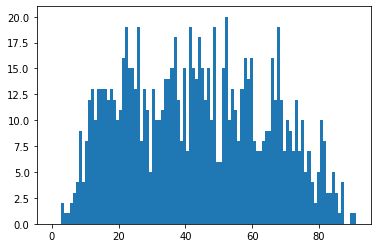

In [3]:
k = 10
adj_matrix,dist_matrix = nn.NeighborhoodGraph(X_cluster,k, symm = True)
adj_assigned, max_weight = nn.assign_weights(adj_matrix,dist_matrix, X_cluster, velo_cluster,scaling = 3,\
                              distance_scaler = 0.5,thresholding = 0.0)
visual.weight_histogram(adj_assigned, scaling=100,upper=max_weight)

In [4]:
paths, opt = path.dijkstra_paths(adj_assigned, indeg = [0,1,2])
clusters = int(np.max(groups)+1)

# dg
# greedy_paths, paths = path.greedy_selection(clusters, paths, opt, threshold = 0.5, max_w=max_weight, cut_off=None, verbose=True, length_bias=0.0, max_trajs = 30)

#pe
greedy_paths, paths = path.greedy_selection(clusters, paths, opt, threshold = 0.5, max_w=max_weight, cut_off=None, verbose=True, length_bias=0.5, max_trajs = 30)

conduct quality control
selected path (starting_ending):
start_end:  295_69 , len:  37 newly covered: 37
start_end:  290_66 , len:  29 newly covered: 12
start_end:  295_32 , len:  34 newly covered: 8
start_end:  295_275 , len:  35 newly covered: 6
start_end:  295_80 , len:  35 newly covered: 3
start_end:  295_78 , len:  36 newly covered: 2
start_end:  295_4 , len:  34 newly covered: 3
start_end:  268_179 , len:  13 newly covered: 13
start_end:  295_280 , len:  35 newly covered: 2
start_end:  295_181 , len:  37 newly covered: 1
start_end:  295_235 , len:  33 newly covered: 3
start_end:  295_108 , len:  36 newly covered: 1
start_end:  295_202 , len:  31 newly covered: 3
start_end:  295_74 , len:  33 newly covered: 2
start_end:  295_279 , len:  33 newly covered: 2
Finished


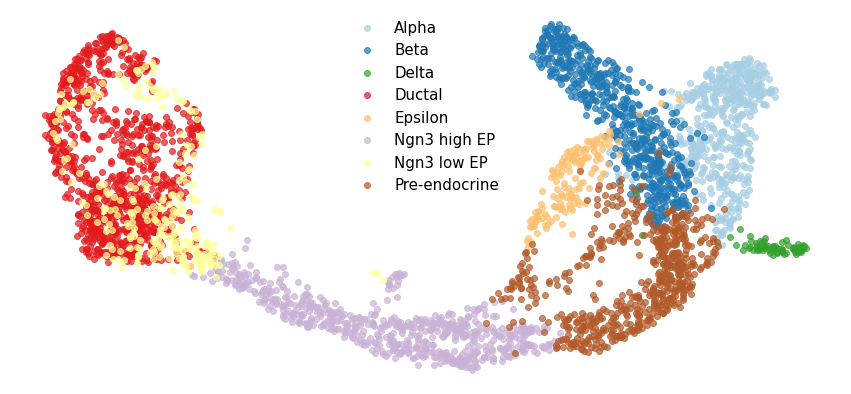

In [5]:
X_umap = adata.obsm['X_umap']

fig = plt.figure(figsize = (15,7))
ax = fig.add_subplot()
ax.axis("off")
cluster_anno = [x for x in adata.obs['clusters'].values]
cluster_uni = [x for x in np.unique(adata.obs['clusters'].values)]

colormap = plt.cm.get_cmap("Paired", len(cluster_uni))
for count, clust in enumerate(cluster_uni):
    idx = np.where(np.array(cluster_anno) == clust)[0]
    ax.scatter(X_umap[idx,0], X_umap[idx,1], color = colormap(count), alpha = 0.7, label = clust)    
ax.legend(loc='upper center', prop={'size': 15}, frameon = False, ncol = 1)
fig.savefig("./real_results/pe/clust_annotation.pdf", bbox_inches = "tight")

In [11]:
import importlib
importlib.reload(visual)

<module 'multraj.visual' from '/Users/ziqizhang/Dropbox/Research/Multi_traj_proj/code/multraj/visual.py'>

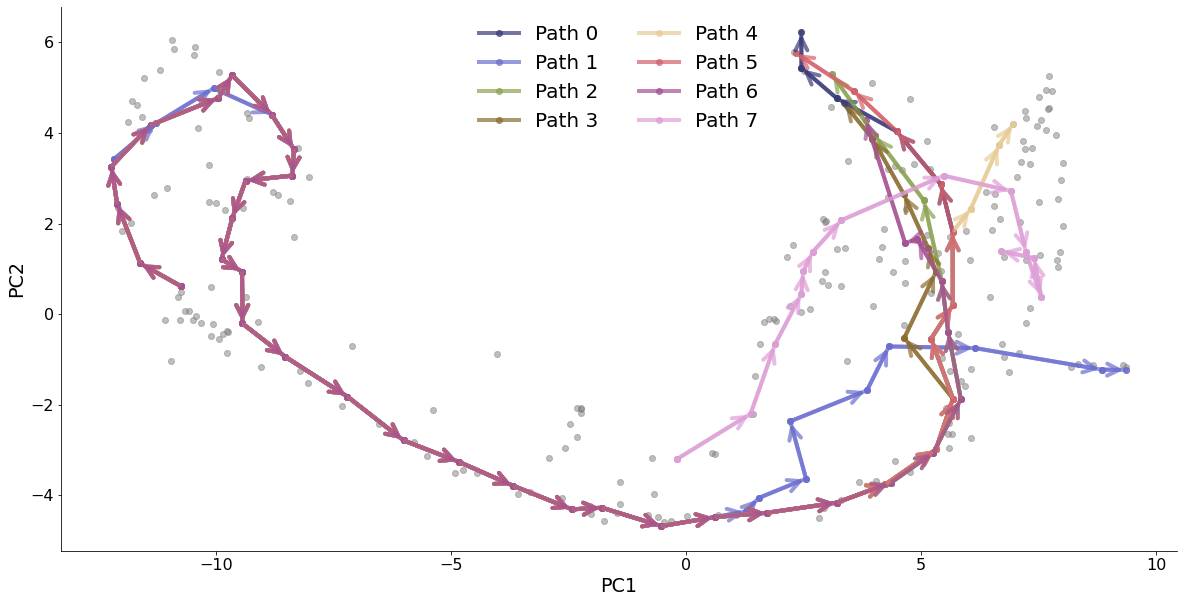

In [12]:
X_umap = adata.obsm['X_umap']
X_umap_cluster = np.zeros((clusters,2))
for c in range(clusters):
    indices = np.where(groups == c)[0]
    X_umap_cluster[c,:] = np.mean(X_umap[indices,:],axis=0)
trajs = 8
visual.meta_traj_visual(X_umap_cluster, paths, greedy_paths, trajs = trajs, figsize = (20,10), save_as = "./real_results/pe/umap_clust_paths.pdf")

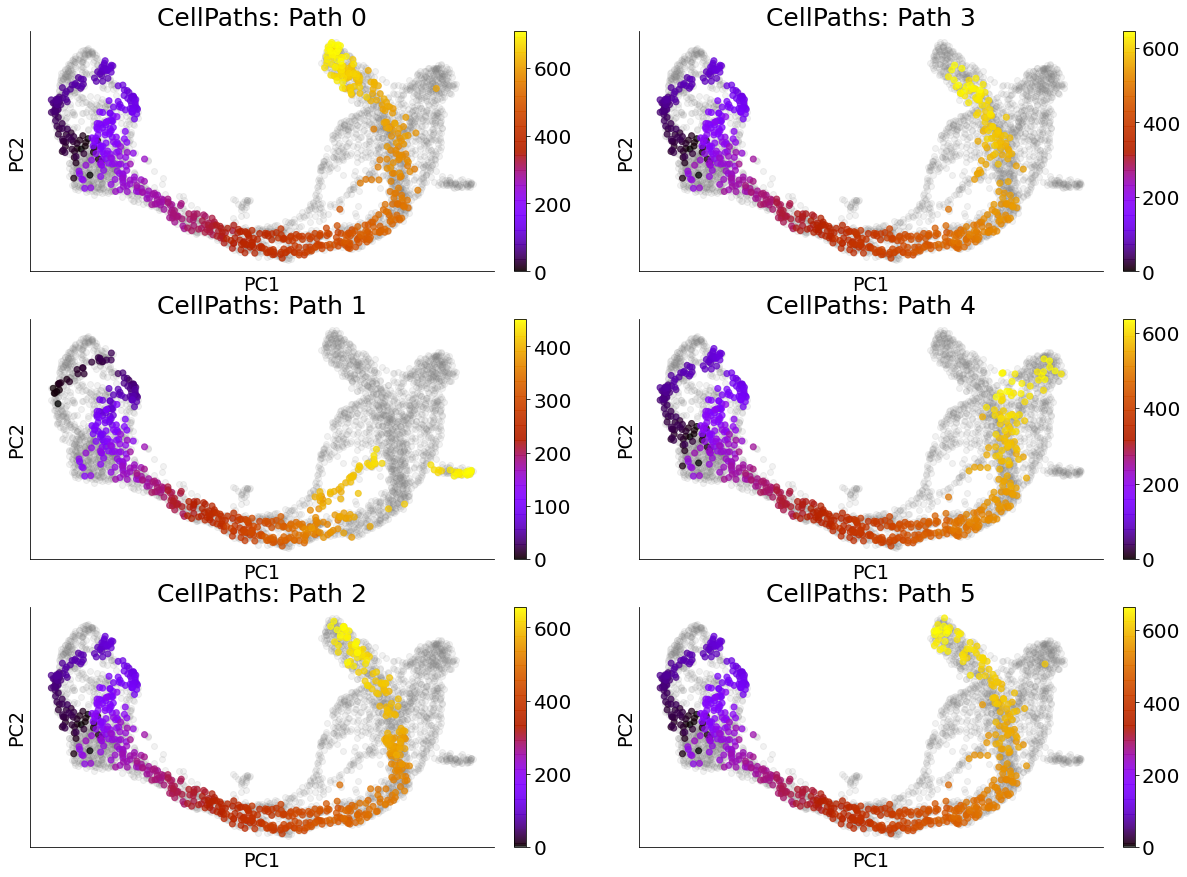

In [10]:
pseudo_order = visual.first_order_approx_pt(adata, paths, greedy_paths, X_cluster, velo_cluster, basis = 'umap', groups = None, trajs = 6, figsize= (20,15), save_as = "./real_results/pe/first_order_approx_pt.pdf")

# Differentially expressed genes

In [24]:
de_genes = de.de_analy(adata, pseudo_order, p_val_t = 0.05, verbose=False)

In [25]:
import json
gene_names_ordered = {}
for reconst_i in de_genes.keys():
    gene_names_ordered[reconst_i] = [{"gene_id": gene["gene"], "p_val": gene["p_val"]} for gene in de_genes[reconst_i]]
with open("./real_results/pe/de_genes_ordered.json","w") as fp:
    json.dump(gene_names_ordered, fp)

In [27]:
for reconst_i in gene_names_ordered.keys():
    with open("./real_results/pe/"+ reconst_i + "/gene_ids_ordered.txt","w") as fp:
        for gene in gene_names_ordered[reconst_i][:200]:
            fp.writelines(gene["gene_id"]+"\n")

In [28]:
# de.de_plot(adata, pseudo_order, de_genes, figsize = (20,40), n_genes = 20, prefix = "./real_results/pe/")

In [27]:
# de.de_heatmap(adata, pseudo_order, de_genes, figsize = (20, 10), n_genes = 20, prefix = "./real_results/pe/")

In [12]:
import pandas as pd

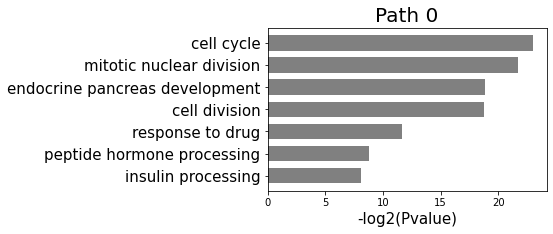

In [24]:
go1 = pd.read_csv("./real_results/pe/reconst_1/David/GO_bp_func_anno_chart.tsv", sep = "\t").iloc[:7]
func = go1['Term']
func = [x.split("~")[1] for x in func]
pval = go1['PValue']
pval = -np.log(pval)

fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot()
barWidth = 0.7
go = ax.barh(np.arange(len(func)), pval.values, height = barWidth, capsize = 7, color = 'gray')

ax.set_xlabel("-log2(Pvalue)", fontsize = 15)
plt.yticks(np.arange(len(func)), func, fontsize = 15)
plt.gca().invert_yaxis()
ax.set_title("Path 0", fontsize = 20)
fig.savefig(fname = "./real_results/pe/GO_path0.png", bbox_inches = 'tight')

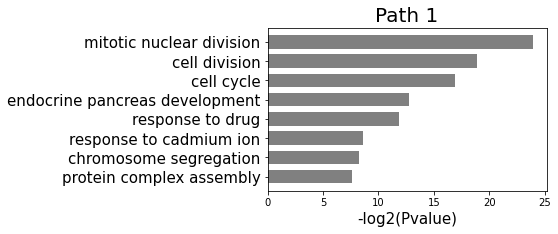

In [25]:
go1 = pd.read_csv("./real_results/pe/reconst_2/David/chart.tsv", sep = "\t").iloc[:8]
func = go1['Term']
func = [x.split("~")[1] for x in func]
pval = go1['PValue']
pval = -np.log(pval)

fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot()
barWidth = 0.7
go = ax.barh(np.arange(len(func)), pval.values, height = barWidth, capsize = 7, color = 'gray')

ax.set_xlabel("-log2(Pvalue)", fontsize = 15)
plt.yticks(np.arange(len(func)), func, fontsize = 15)
plt.gca().invert_yaxis()
ax.set_title("Path 1", fontsize = 20)
fig.savefig(fname = "./real_results/pe/GO_path1.png", bbox_inches = 'tight')

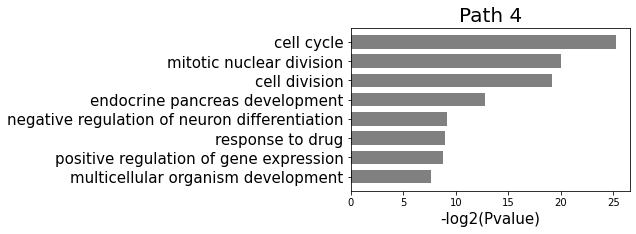

In [26]:
go1 = pd.read_csv("./real_results/pe/reconst_5/David/chart.tsv", sep = "\t").iloc[:8]
func = go1['Term']
func = [x.split("~")[1] for x in func]
pval = go1['PValue']
pval = -np.log(pval)

fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot()
barWidth = 0.7
go = ax.barh(np.arange(len(func)), pval.values, height = barWidth, capsize = 7, color = 'gray')

ax.set_xlabel("-log2(Pvalue)", fontsize = 15)
plt.yticks(np.arange(len(func)), func, fontsize = 15)
plt.gca().invert_yaxis()
ax.set_title("Path 4", fontsize = 20)
fig.savefig(fname = "./real_results/pe/GO_path4.png", bbox_inches = 'tight')